# Import Dependencies

We begin by importing the necessary libraries.

In [1]:
# System & OS
import os

# Data analysis
import numpy as np
import pandas as pd
pd.options.display.max_columns = None

# ML
from sklearn.model_selection import train_test_split, KFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, ConfusionMatrixDisplay

# Data visualization
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
sns.set()
sns.set_style('white')

# Reproducibility

Set the seed to ensure our results are reproducible.

In [2]:
def set_seed(seed):
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)

SEED = 11
set_seed(SEED)

# Data Cleaning

Next, read in the `Pitching` dataframe from the `Lahman` package. Note, a separate R script was used to export the data into a CSV file.

In [3]:
# Read data & drop irrelevant columns
df = pd.read_csv('../data/pitching_df.csv')
df.drop(columns=['Unnamed: 0'], inplace=True)

# Display results
df.head()

,playerID,yearID,stint,teamID,lgID,W,L,G,GS,CG,SHO,SV,IPouts,H,ER,HR,BB,SO,BAOpp,ERA,IBB,WP,HBP,BK,BFP,GF,R,SH,SF,GIDP
0,bechtge01,1871,1,PH1,NaN,1,2,3,3,2,0,0,78,43,23,0,11,1,NaN,7.96,NaN,7,NaN,0,146.0,0,42,NaN,NaN,NaN
1,brainas01,1871,1,WS3,NaN,12,15,30,30,30,0,0,792,361,132,4,37,13,NaN,4.50,NaN,7,NaN,0,1291.0,0,292,NaN,NaN,NaN
2,fergubo01,1871,1,NY2,NaN,0,0,1,0,0,0,0,3,8,3,0,0,0,NaN,27.00,NaN,2,NaN,0,14.0,0,9,NaN,NaN,NaN
3,fishech01,1871,1,RC1,NaN,4,16,24,24,22,1,0,639,295,103,3,31,15,NaN,4.35,NaN,20,NaN,0,1080.0,1,257,NaN,NaN,NaN
4,fleetfr01,1871,1,NY2,NaN,0,1,1,1,1,0,0,27,20,10,0,3,0,NaN,10.00,NaN,0,NaN,0,57.0,0,21,NaN,NaN,NaN


Apply the following cleaning steps:

1. Remove entries that don't fall between 2010 and 2019
2. Remove entries that didn't occur in the American League
3. Remove entries* that have less than 100 batters faced

*each stint by a given pitcher in a season is treated as a distinct instance.

We'll also create a new feature: home runs allowed per batter faced (`HRPBF`), which will be of use later on.

In [4]:
# Filter for rows between 2010 and 2019
df = df[(df['yearID'] >= 2010) & (df['yearID'] <= 2019)]

# Filter for American League pitchers
df = df[df['lgID'] == 'AL']

# Filter for rows with BFP >= 100
df = df[df['BFP'] >= 100].reset_index(drop=True)

# New feature: home runs allowed per batter faced
df['HRPBF'] = df['HR'] / df['BFP']

# Display results
df.head()

,playerID,yearID,stint,teamID,lgID,W,L,G,GS,CG,SHO,SV,IPouts,H,ER,HR,BB,SO,BAOpp,ERA,IBB,WP,HBP,BK,BFP,GF,R,SH,SF,GIDP,HRPBF
0,aardsda01,2010,1,SEA,AL,0,6,53,0,0,0,31,149,33,19,5,25,49,0.198,3.44,5.0,2,2.0,0,202.0,43,19,7.0,1.0,5.0,0.024752
1,alberma01,2010,1,BAL,AL,5,3,62,0,0,0,0,227,78,38,6,34,49,0.269,4.52,5.0,2,2.0,0,329.0,19,41,3.0,0.0,12.0,0.018237
2,ambrihe01,2010,1,CLE,AL,0,2,34,0,0,0,0,145,68,30,10,17,37,0.338,5.59,1.0,4,1.0,0,224.0,20,31,2.0,3.0,6.0,0.044643
3,anderbr04,2010,1,OAK,AL,7,6,19,19,0,0,0,337,112,35,6,22,75,0.257,2.80,2.0,4,7.0,2,470.0,0,41,3.0,2.0,12.0,0.012766
4,arrieja01,2010,1,BAL,AL,6,6,18,18,0,0,0,301,106,52,9,48,52,0.271,4.66,3.0,5,4.0,0,449.0,0,57,4.0,2.0,10.0,0.020045


# Question 1

*"The median ERA (earned run average) is around 4, so let’s classify those pitchers with an ERA less than 4 as 'low ERA'. Add a column to your data frame with this classification."*

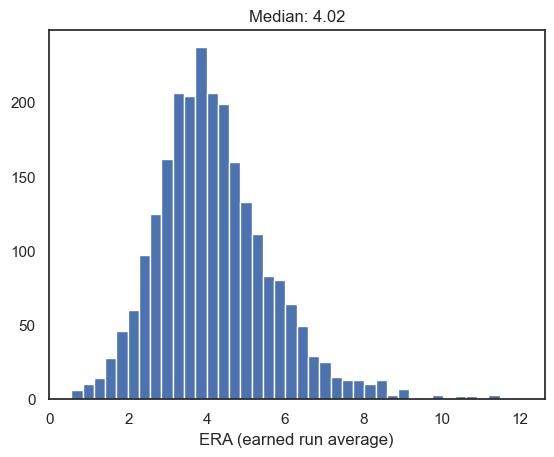

In [5]:
# Visualize the distribution of ERA
df['ERA'].plot(kind='hist', bins=40)
plt.title(f'Median: {df["ERA"].median():.2f}')
plt.xlabel('ERA (earned run average)')
plt.ylabel('')
plt.show()

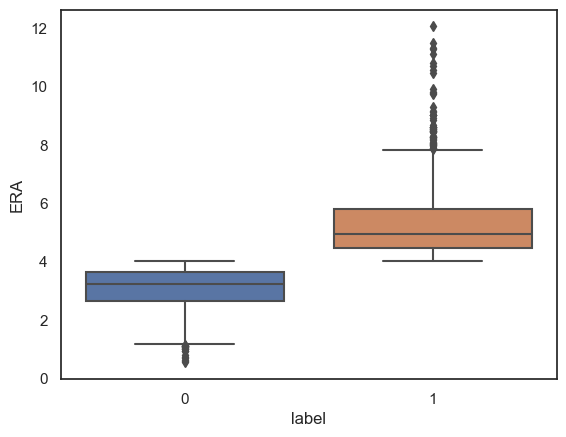

In [6]:
# Create target variable based on median ERA value
df['label'] = 0
df.loc[df['ERA'] >= df['ERA'].median(), 'label'] = 1

# Visualize results using boxplots
sns.boxplot(x='label', y='ERA', data=df)
plt.show()

As we can see, all ERA values below 4.02 are labeled as 0 for "low ERA", and the rest as 1 for "high ERA". 

# Question 2

*"Form the training and testing data frames. Use an 80% - 20% split."*

In [7]:
# 80/20 train-test split
train_df, test_df = train_test_split(df, test_size=0.2, random_state=SEED)

# Print results
print(f'Original: {len(df)} entries\nTrain: {len(train_df)} entries\nTest: {len(test_df)} entries')

Original: 2422 entries
Train: 1937 entries
Test: 485 entries


# Question 3

*"The 'null model' simply predicts that every pitcher is 'high ERA.' What is its accuracy?"*

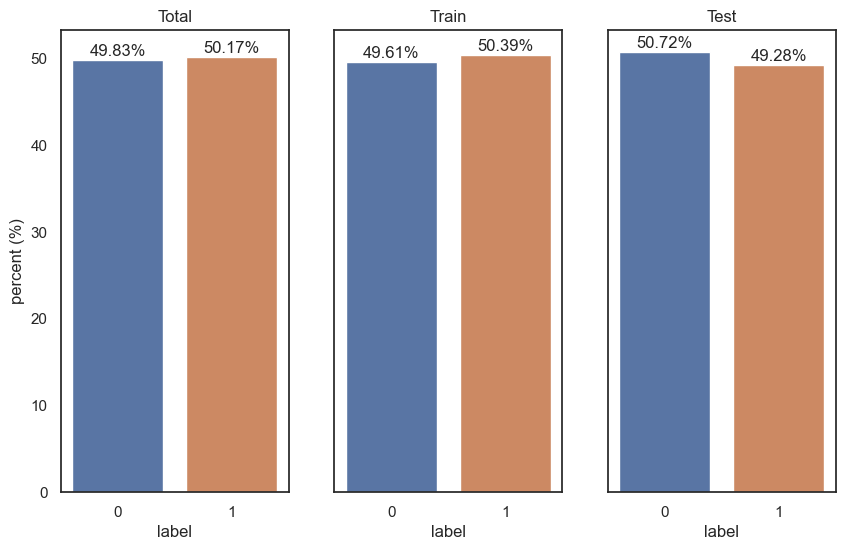

In [8]:
# Perform a normalized value count to obtain the percentage of values in each class
label_counts = df['label'].value_counts(normalize=True).apply(lambda x: x * 100).reset_index()
label_counts.rename(columns={'index': 'label', 'label': 'percent'}, inplace=True)
label_counts.sort_values(by='label', inplace=True)

train_label_counts = train_df['label'].value_counts(normalize=True).apply(lambda x: x * 100).reset_index()
train_label_counts.rename(columns={'index': 'label', 'label': 'percent'}, inplace=True)
train_label_counts.sort_values(by='label', inplace=True)

test_label_counts = test_df['label'].value_counts(normalize=True).apply(lambda x: x * 100).reset_index()
test_label_counts.rename(columns={'index': 'label', 'label': 'percent'}, inplace=True)
test_label_counts.sort_values(by='label', inplace=True)

# Visualize results using a bar graph
fig, ax = plt.subplots(1, 3, figsize=(10, 6), sharey=True)
sns.barplot(x='label', y='percent', data=label_counts, ax=ax[0])
sns.barplot(x='label', y='percent', data=train_label_counts, ax=ax[1])
sns.barplot(x='label', y='percent', data=test_label_counts, ax=ax[2])

ax[0].set_title('Total')
ax[1].set_title('Train')
ax[2].set_title('Test')
ax[0].set_ylabel('percent (%)')
ax[1].set_ylabel('')
ax[2].set_ylabel('')
for index, value in enumerate(label_counts['percent']):
    ax[0].text(index, value+0.5, f'{round(value, 2)}%', ha='center')
for index, value in enumerate(train_label_counts['percent']):
    ax[1].text(index, value+0.5, f'{round(value, 2)}%', ha='center')
for index, value in enumerate(test_label_counts['percent']):
    ax[2].text(index, value+0.5, f'{round(value, 2)}%', ha='center')

plt.show()

Notice, the class distributions are fairly balanced across all three splits, implying that the train-test split was likely executed as expected. Assuming the null model predicts the label to be 1 (i.e. high ERA) every time, we can expect a baseline accuracy of roughly 50%.

# Question 4

*"Perhaps `HR` (home runs allowed) is a good predictor. Actually, we should normalize this; that is, use `HR/BFP` (home runs allowed divided by number of batters faced). Build a classifier with this variable as the only predictor; call it `model_1`. How does it do (on the training set)? (Compute its accuracy and its confusion matrix.)"*

In [9]:
# Split the dataframes into X (features) and y (target)
X, y, X_test, y_test = train_df['HRPBF'].values.reshape(-1, 1), train_df['label'].values, test_df['HRPBF'].values.reshape(-1, 1), test_df['label'].values

# Create logistic regression object
model_1 = LogisticRegression(random_state=SEED)

# Define index & number of splits
i, k = 1, 10
# Create k-fold cross-val object
kf = KFold(n_splits=k)

# Iterate over each fold
for train_index, val_index in kf.split(X):
    # Split the data into training and validation sets for the current fold
    X_train, y_train, X_val, y_val = X[train_index], y[train_index], X[val_index], y[val_index]
    
    # Fit the model to train
    model_1.fit(X_train, y_train)

    # Generate model predictions on val
    y_val_pred = model_1.predict(X_val)
    
    # Calculate and print the model's current validation accuracy
    val_accuracy = accuracy_score(y_val, y_val_pred) * 100
    print(f'Fold {i}, validation accuracy: {val_accuracy:.2f}%')
    i += 1

Fold 1, validation accuracy: 67.53%
Fold 2, validation accuracy: 66.49%
Fold 3, validation accuracy: 70.10%
Fold 4, validation accuracy: 70.10%
Fold 5, validation accuracy: 70.62%
Fold 6, validation accuracy: 68.56%
Fold 7, validation accuracy: 63.40%
Fold 8, validation accuracy: 68.91%
Fold 9, validation accuracy: 67.88%
Fold 10, validation accuracy: 69.43%


Beta_1: 4.9852, Beta_0: -0.1204
BA decision boundary: 0.024


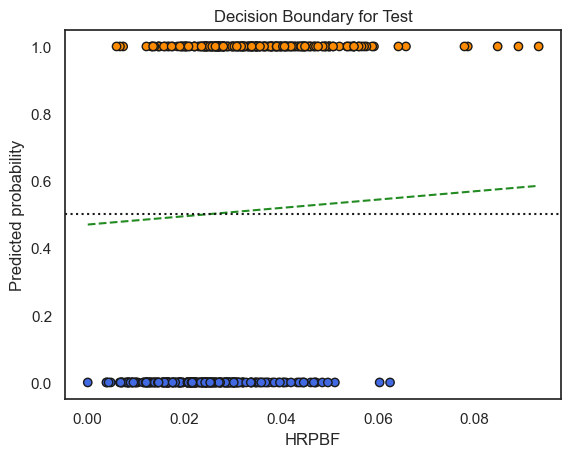

In [10]:
# Print model coefficients
beta_0, beta_1 = model_1.intercept_[0], model_1.coef_[0][0]
thresh = - beta_0 / beta_1
print(f'Beta_1: {beta_1:.4f}, Beta_0: {beta_0:.4f}')
print(f'BA decision boundary: {thresh:.3f}')

# Define logistic function
def logistic(x):
    return 1 / (1 + np.exp(-x))

# Define predicted probabilities function
def decision_boundary(model, x):
    return logistic(model.coef_ * x + model.intercept_)[0]

# Define plotting function 
def plot_decision_boundary(model, X, y):
    plt.scatter(X, y, c=y, cmap=mcolors.LinearSegmentedColormap.from_list('my_cmap', [mcolors.CSS4_COLORS['royalblue'], 'white', mcolors.CSS4_COLORS['darkorange']]), edgecolors='k')
    x_plot = np.linspace(np.min(X), np.max(X), 1000)
    y_plot = decision_boundary(model, x_plot)
    plt.plot(x_plot, y_plot, c='forestgreen', linestyle='--')
    plt.axhline(0.5, c='k', linestyle=':')
    plt.title('Decision Boundary for Test')
    plt.xlabel('HRPBF')
    plt.ylabel('Predicted probability')
    plt.show()
    
# Visualize logistic regression's decision boundary with points in test
plot_decision_boundary(model_1, X_test, y_test)

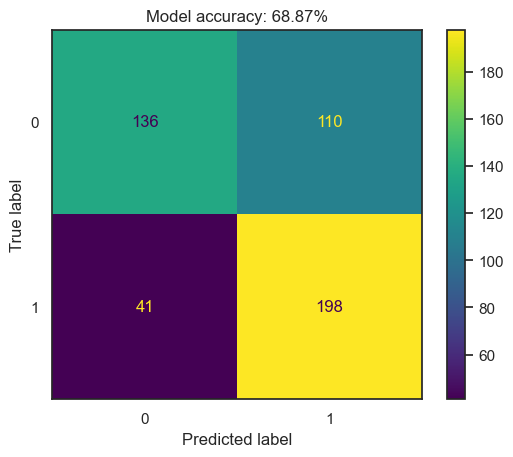

In [11]:
# Generate model predictions on test
y_pred = model_1.predict(X_test)

# Compute model accuracy
accuracy = accuracy_score(y_test, y_pred) * 100

# Calculate and display the confusion matrix
ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
plt.title(f'Model accuracy: {accuracy:.2f}%')
plt.show()

As we can see, a logistic regression classifier with a single predictor `HRPBF` achieves a validation accuracy of roughly 70%; a test accuracy of 68.87%, with 22.68% and 8.45% Type I and II error rate, respectively. These are all significant improvements w.r.t. the null model!

Additionally, we infer a practical decision boundary of 0.024, i.e. the model labels observations with `HRPBF > 0.024` as high ERA, and low ERA otherwise. 

# Questions 5 & 6

*"Determine a numeric variable whose mean value for the low-ERA pitchers is different than its mean value for the high-ERA pitchers (in the sense that the confidence interval for the difference does not contain 0). Using `tally()` or appropriate graphs, show that this variable may be a good predictor. Add this predictor to `model_1` to obtain `model_2`. How does it do? (In addition to computing its accuracy and confusion matrix, produce a summary using `broom::tidy(model_2)`. Interpret it.)"*

*"Apply `model_2` to the testing set. How does it do?"*

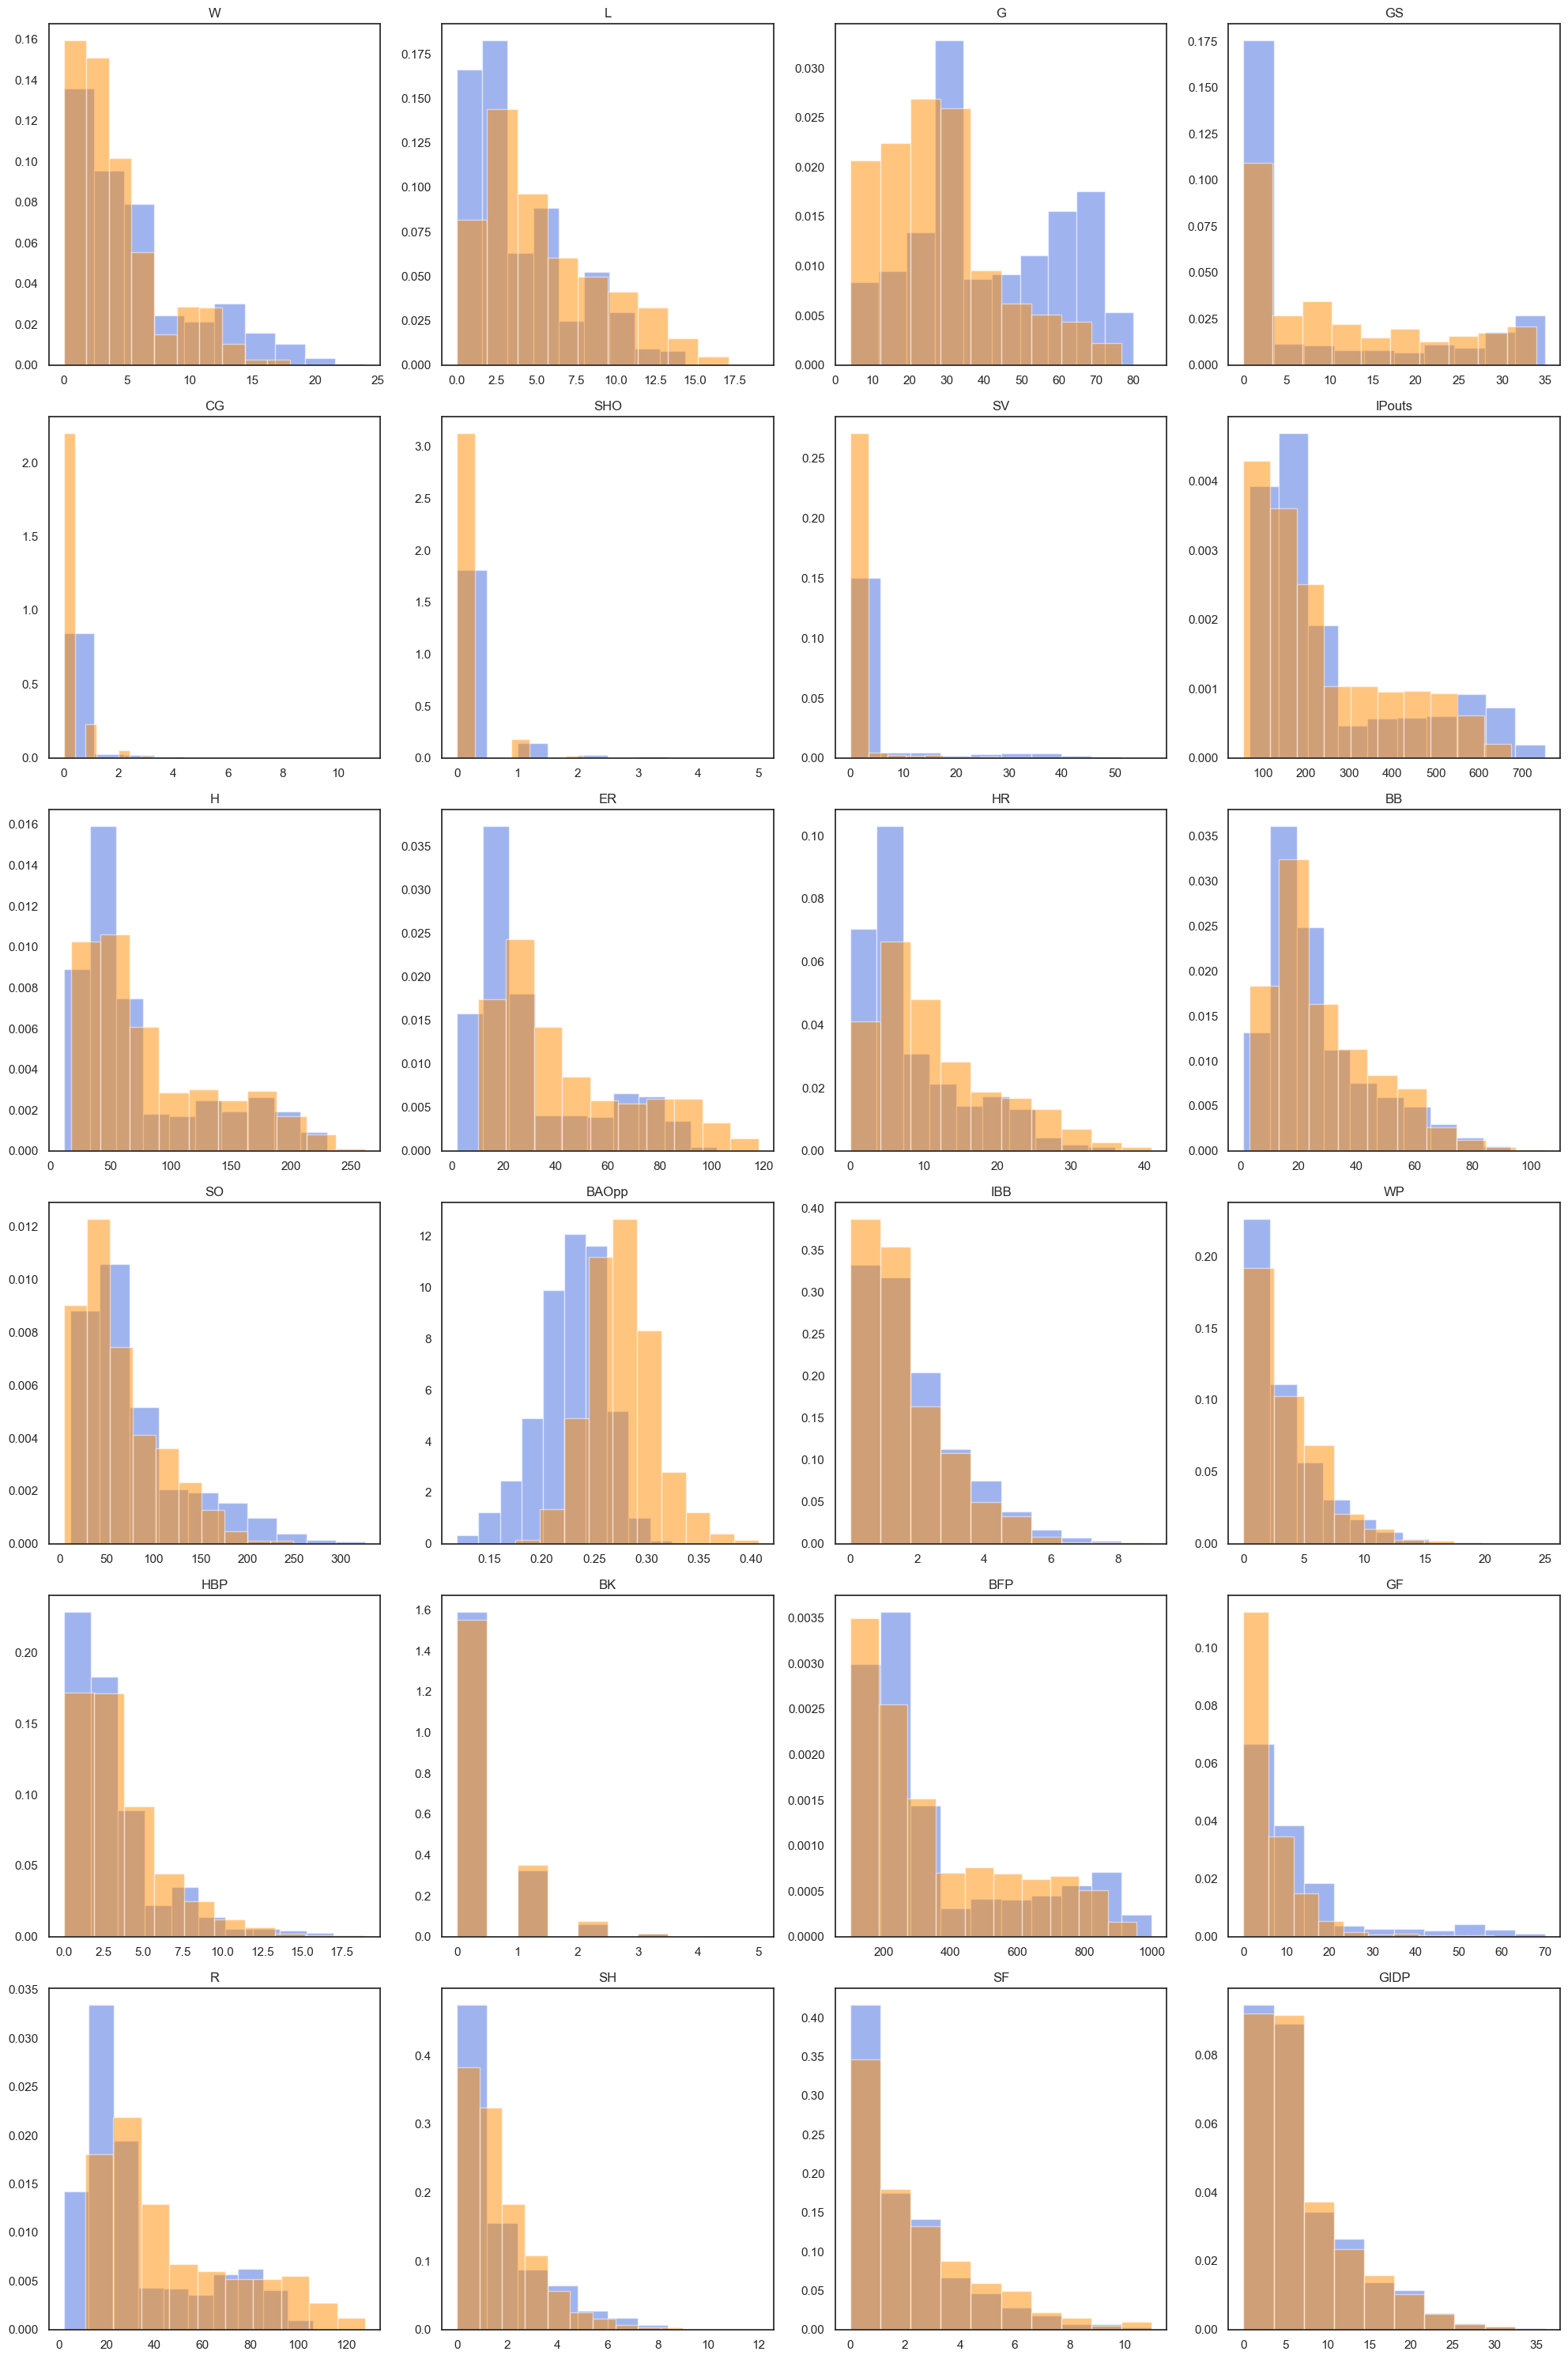

In [12]:
# Define the number of subplots per row
num_subplots_per_row = 4

# Get the number of relevant features in df
features = ['W', 'L', 'G', 'GS', 'CG', 'SHO', 'SV', 'IPouts', 'H', 'ER', 'HR', 'BB', 'SO', 'BAOpp', 'IBB', 'WP', 'HBP', 'BK', 'BFP', 'GF', 'R', 'SH', 'SF', 'GIDP']
num_features = len(features)

# Calculate the number of rows needed in figure
num_rows = int(np.ceil(num_features / num_subplots_per_row))

# Create the figure and axes objects
fig, ax = plt.subplots(num_rows, num_subplots_per_row, figsize=(20, 5*num_rows))

# Flatten the axes array
ax = ax.flatten()

# Loop through the features and create a histogram for each one
for i, feature in enumerate(df[features].columns):
    # Get the subplot index
    subplot_index = i % num_subplots_per_row + (i // num_subplots_per_row) * num_subplots_per_row

    # Plot the histogram for the current feature
    for label, color in zip([0, 1], ['royalblue', 'darkorange']):
        ax[subplot_index].hist(df[df['label'] == label][feature], alpha=0.5, color=color, density=True)

    # Set the subplot title
    ax[subplot_index].set_title(feature)

# Remove any unused subplots
for i in range(num_features, num_rows*num_subplots_per_row):
    fig.delaxes(ax[i])

# Adjust the spacing between subplots
fig.tight_layout()

# Show the plot
plt.show()

From the above plot, we deduce that `BAOpp` (opponent's batting average) is likely the best choice for our 2nd predictor, since its mean as a function of `label` remains visually distinct. Indeed, this makes intuitive sense in the context of baseball. 

Sanity check: let's verify this decision via its multiple regression plot.

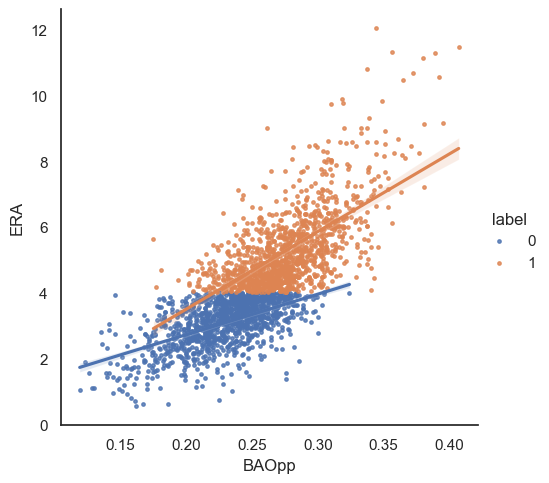

In [13]:
# Multiple regression plot
sns.lmplot(data=df, x='BAOpp', y='ERA', hue='label', scatter_kws={'s': 6})
plt.show()

With there being clear separation between classes as a function of `BAOpp`, we can proceed accordingly!

In [14]:
# Split the dataframes into X (features) and y (target)
X, y, X_test, y_test = train_df[['HRPBF', 'BAOpp']].values, train_df['label'].values, test_df[['HRPBF', 'BAOpp']].values, test_df['label'].values

# Create logistic regression object
model_2 = LogisticRegression(random_state=SEED)

# Define index & number of splits
i, k = 1, 10
# Create k-fold cross-val object
kf = KFold(n_splits=k)

# Iterate over each fold
for train_index, val_index in kf.split(X):
    # Split the data into training and validation sets for the current fold
    X_train, y_train, X_val, y_val = X[train_index], y[train_index], X[val_index], y[val_index]
    
    # Fit the model to train
    model_2.fit(X_train, y_train)

    # Generate model predictions on val
    y_val_pred = model_2.predict(X_val)
    
    # Calculate and print the model's current validation accuracy
    val_accuracy = accuracy_score(y_val, y_val_pred) * 100
    print(f'Fold {i}, validation accuracy: {val_accuracy:.2f}%')
    i += 1

Fold 1, validation accuracy: 78.87%
Fold 2, validation accuracy: 79.90%
Fold 3, validation accuracy: 81.96%
Fold 4, validation accuracy: 77.84%
Fold 5, validation accuracy: 78.87%
Fold 6, validation accuracy: 78.35%
Fold 7, validation accuracy: 77.32%
Fold 8, validation accuracy: 77.20%
Fold 9, validation accuracy: 86.01%
Fold 10, validation accuracy: 77.20%


In [15]:
# Print model coefficients
beta_0, beta_1, beta_2 = model_2.intercept_[0], model_2.coef_[0][0], model_2.coef_[0][1]
print(f'Beta_2: {beta_2:.4f}, Beta_1: {beta_1:.4f}, Beta_0: {beta_0:.4f}')

# Print decision boundaries using mean of unused predictor
HRPBF_mean, BAOpp_mean = X[:, 0].mean(), X[:, 1].mean()
thresh_1, thresh_2 = - (beta_0 + beta_2 * BAOpp_mean) / beta_1, - (beta_0 + beta_1 * HRPBF_mean) / beta_2
print(f'HRPBF Decision boundary: {thresh_1:.4f}\nBAOpp Decision boundary: {thresh_2:.4f}')

Beta_2: 12.6467, Beta_1: 4.0909, Beta_0: -3.2821
HRPBF Decision boundary: 0.0224
BAOpp Decision boundary: 0.2501


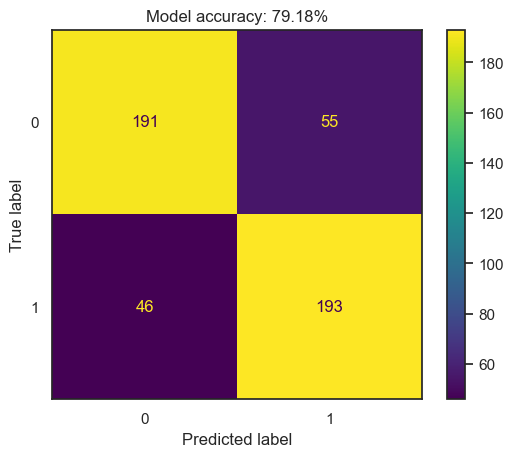

In [16]:
# Generate model predictions on test
y_pred = model_2.predict(X_test)

# Compute model accuracy
accuracy = accuracy_score(y_test, y_pred) * 100

# Calculate and display the confusion matrix
ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
plt.title(f'Model accuracy: {accuracy:.2f}%')
plt.show()

We find that a logistic regression classifier with 2 predictors `HRPBF` and `BAOpp` achieves a validation accuracy of roughly 81%; a test accuracy of 79.18%, with 11.34% and 9.48% Type I and II error rate, respectively. These are all significant improvements w.r.t. both the null model and `model_1`!